In [1]:
!pip install -qq pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 50.7 MB/s eta 0:00:00


In [2]:
!wget -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=16hd28VqzufDp8gpmIAC4UFAKAPbIrD4R" -O negative.csv
!wget -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1NeluUImkZjwYTVZzK0RehtbWf3BKPike" -O positive.csv

In [3]:
import warnings
warnings.filterwarnings("ignore")

import re
from collections import Counter
import string
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB

import nltk
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from nltk.corpus import stopwords
from nltk import FreqDist

from pymorphy2 import MorphAnalyzer

import tensorflow as tf

pd.set_option("display.max_colwidth", None)
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
pymorphy2_analyzer = MorphAnalyzer()
wp_tokenize = WordPunctTokenizer()
punctuation = string.punctuation

russian = stopwords.words("russian")
english = stopwords.words("english")

In [5]:
positive = pd.read_csv("positive.csv", sep=";", usecols=[3], header=None).rename(columns={3: "text"})
negative = pd.read_csv("negative.csv", sep=";", usecols=[3], header=None).rename(columns={3: "text"})
positive["label"] = 0
negative["label"] = 1
df = pd.concat([positive, negative], axis=0).sample(frac=1)

df.head()

,text,label
77898,"так привыкла за эти дни к @AnastasiaMurMur , что сейчас одной дома не по себе;(",1
3950,"Если бы вы знали,как я устала.. постоянно жуткие головные боли и головокружения. Часто приходится спать сидя, так как таблетки не помогают((",1
76312,"В моей жизни появился такой классный человек, спасибо тебе:)",0
76933,@ln_summer @964269 а сам ПУ нехай присоединяет к своему ТС КНДР и узбагаиваецца :-),0
93625,"""@SmokyMo46: Аааааааа) http://t.co/FM1nyn9zlu "" эбать курица, овца явно иностранка с ЕС))))))))",0


In [6]:
from sklearn.preprocessing import normalize
df["label"].value_counts(normalize=True)

0    0.506586
1    0.493414
Name: label, dtype: float64

In [7]:
emoticon_dict = {
                ":)": "счастье",
                ":))": "счастье",
                ":‑)": "счастье",
                ":-]": "счастье",
                ":-3": "счастье",
                ":->": "счастье",
                "8-)": "счастье",
                ":-}": "счастье",
                ":o)": "счастье",
                ":c)": "счастье",
                ":^)": "счастье",
                "=]": "счастье",
                "=)": "счастье",
                "<3": "счастье",
                ":D": "счастье",
                ":-D": "счастье",
                "))": "счастье",
                ":-(": "плохо",
                ":(": "плохо",
                ":c": "плохо",
                ":<": "плохо",
                ":[": "плохо",
                ">:[": "плохо",
                ":{": "плохо",
                ">:(": "плохо",
                ":-c": "плохо",
                ":-< ": "плохо",
                ":-[": "плохо",
                "((": "плохо",
                ":((": "плохо",
                ":-||": "плохо"
        }

emo_list = list(emoticon_dict.keys())

In [8]:
def preprocess(text: str, 
               remove_punct: bool = False,
               lemma: bool = True) -> list:

    if not isinstance(text, str):
        text = str(text)

    text = re.sub("@[\w]*", ' ', text)
    text = re.sub(r'http\S+', '', text)

    s = ''
    for token in text.split():
        if token in emo_list:
            s += emoticon_dict[token] + " "
        else:
            s += token + " "
    text = s.rstrip()

    text = re.sub("\s\s+", " ", text)
    if remove_punct:
        text = re.sub(r"[^a-zA-Zа-яА-Я0-9]", " ", text)
        text = re.sub(r"[^a-zA-Zа-яА-Я]", " ", text)
        text = re.sub(r"[^\w\s]", " ", text)
    else:
        text = re.sub(f"[^a-zA-Zа-яА-Я{punctuation}]", " ", text)

    text = text.lower().strip().replace(',', '')
    text = [w for w in text.split() if len(w)>1]
    text = ' '.join([w for w in text if w not in russian and w not in english])
    
    text = wp_tokenize.tokenize(text)
    if lemma:
        text = [pymorphy2_analyzer.parse(w)[0].normal_form for w in text]
    
    return text

In [9]:
df["text_prep"] = df["text"].apply(preprocess)

count    226834.000000
mean          9.301763
std           4.183685
min           0.000000
25%           6.000000
50%           9.000000
75%          12.000000
max          72.000000
Name: text_prep, dtype: float64

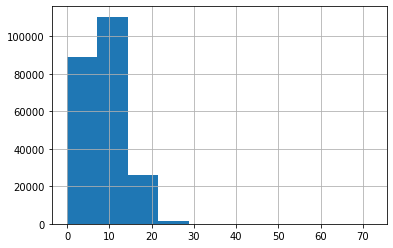

In [ ]:
df["text_prep"].apply(len).hist()
df["text_prep"].apply(len).describe()  # 99.7 percentile = 24

In [ ]:
corpus = [token for tweet in df.text_prep for token in tweet if token not in punctuation]
freq_dict = Counter(corpus)
freq_dict_sorted = sorted(freq_dict.items(), key=lambda x: -x[1])

In [ ]:
vocab_size = len(freq_dict_sorted)

high_freq_corpus = freq_dict_sorted[:vocab_size//3]
middle_freq_corpus = freq_dict_sorted[vocab_size//3: 2*vocab_size//3]
low_freq_corpus = freq_dict_sorted[2*vocab_size//3:]

In [ ]:
# too long and inefficient
# df["high"] = df["text_prep"].apply(lambda x: [w for w in x if w in high_freq_corpus])

In [ ]:
# full corpus for not to miss out rare tokens (despite some data leakage)

# max_df: "ignore terms that appear in more than N documents"
# min_df: "ignore terms that appear in less than N documents"
high_tf = CountVectorizer(lowercase=False, ngram_range=(1, 2), max_features=None, min_df=485).fit(df["text_prep"].apply(' '.join))
middle_tf = CountVectorizer(lowercase=False, ngram_range=(1, 2), max_features=500, min_df=220, max_df=485).fit(df["text_prep"].apply(' '.join))
low_tf = CountVectorizer(lowercase=False, ngram_range=(1, 2), max_features=500, max_df=100).fit(df["text_prep"].apply(' '.join))

In [ ]:
freqs_names = ["high", "middle", "low"]

for vect, tst in zip((high_tf, middle_tf, low_tf), freqs_names):
    print(f"Experiment {tst}: {len(low_tf.get_feature_names())}")

Experiment high: 500
Experiment middle: 500
Experiment low: 500


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df["text_prep"], df["label"], shuffle=True, random_state=42)

In [ ]:
for vect, tst in zip((high_tf, middle_tf, low_tf), freqs_names):
    train_x = vect.transform(x_train.apply(' '.join))
    test_x = vect.transform(x_test.apply(' '.join))
    lr = LogisticRegression(random_state=42).fit(train_x, y_train)
    y_train_pred = lr.predict(train_x)
    y_test_pred = lr.predict(test_x)
    print(f"Experiment {tst}: ")
    print(classification_report(y_train, y_train_pred))
    print(classification_report(y_test, y_test_pred))
    print("="*30)

# low-frequency tokens (terms) are less able to display tweet sentiment (feeling expression relies on more common words or symbols)

Experiment high: 
              precision    recall  f1-score   support

           0       0.73      0.74      0.74     86048
           1       0.73      0.71      0.72     84077

    accuracy                           0.73    170125
   macro avg       0.73      0.73      0.73    170125
weighted avg       0.73      0.73      0.73    170125

              precision    recall  f1-score   support

           0       0.73      0.74      0.73     28863
           1       0.72      0.72      0.72     27846

    accuracy                           0.73     56709
   macro avg       0.73      0.73      0.73     56709
weighted avg       0.73      0.73      0.73     56709

Experiment middle: 
              precision    recall  f1-score   support

           0       0.55      0.84      0.67     86048
           1       0.65      0.30      0.41     84077

    accuracy                           0.57    170125
   macro avg       0.60      0.57      0.54    170125
weighted avg       0.60      0.57   

In [ ]:
pipe = make_pipeline(CountVectorizer(ngram_range=(1,2), max_features=800), LogisticRegression(random_state=42)).fit(x_train.apply(' '.join), y_train)
y_train_pred = pipe.predict(x_train.apply(' '.join))
y_test_pred = pipe.predict(x_test.apply(' '.join))

print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))
# overfitted model

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     86048
           1       0.98      0.98      0.98     84077

    accuracy                           0.98    170125
   macro avg       0.98      0.98      0.98    170125
weighted avg       0.98      0.98      0.98    170125

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     28863
           1       0.79      0.79      0.79     27846

    accuracy                           0.79     56709
   macro avg       0.79      0.79      0.79     56709
weighted avg       0.79      0.79      0.79     56709



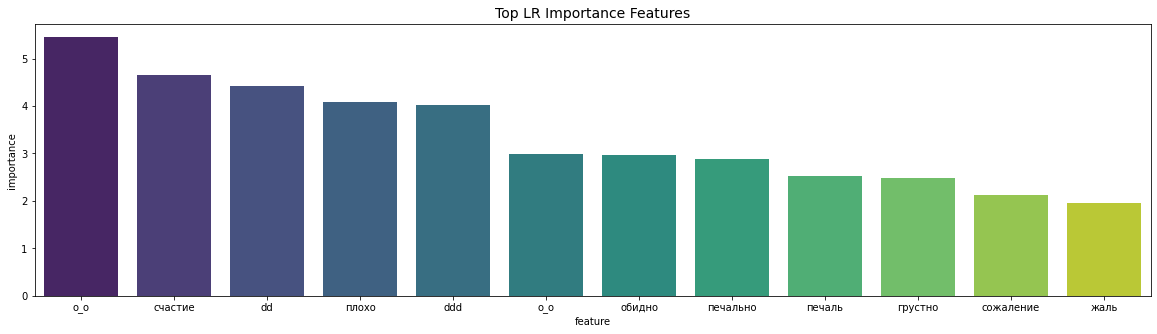

In [ ]:
importance = pd.DataFrame({"importance": np.abs(pipe[-1].coef_.flatten()), "feature": pipe[0].get_feature_names_out()})

importance = importance.sort_values(by="importance", ascending=False)
importance = importance.head(n=12)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["importance"], palette="viridis")
plt.title("Top LR Importance Features", size=14)
plt.show()

In [6]:
x_train, x_test, y_train, y_test = train_test_split(df["text"], df["label"], shuffle=True, random_state=42)

In [ ]:
pipe2 = make_pipeline(TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize),
                      LogisticRegression(random_state=42))

pipe2.fit(x_train, y_train)
pred = pipe2.predict(x_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28905
           1       1.00      1.00      1.00     27804

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



In [15]:
count_based = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, max_features=1500)
naive = GaussianNB()

x_train_transformed = count_based.fit_transform(x_train)
x_test_transformed = count_based.transform(x_test)
naive.fit(x_train_transformed.toarray(), y_train)

GaussianNB()

In [16]:
pred = naive.predict(x_test_transformed.toarray())
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     28725
           1       0.99      0.98      0.99     27984

    accuracy                           0.99     56709
   macro avg       0.99      0.99      0.99     56709
weighted avg       0.99      0.99      0.99     56709



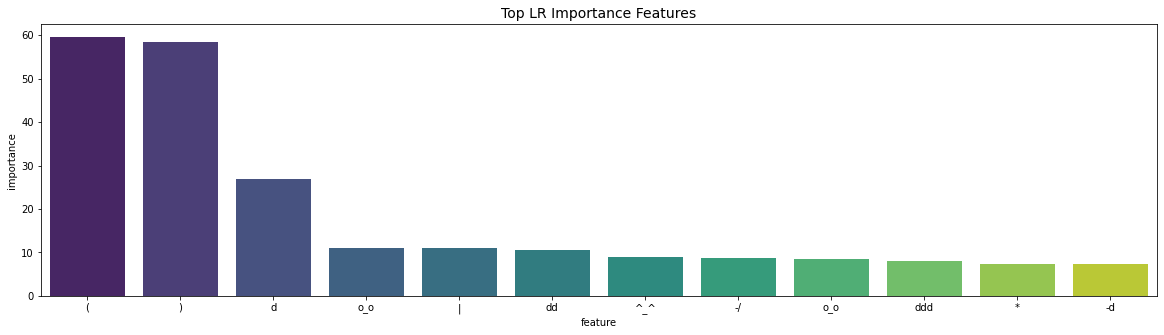

In [ ]:
importance = pd.DataFrame({"importance": np.abs(pipe2[1].coef_.flatten()), "feature": pipe2[0].get_feature_names_out()})

importance = importance.sort_values(by="importance", ascending=False)
importance = importance.head(n=12)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["importance"], palette="viridis")
plt.title("Top LR Importance Features", size=14)
plt.show()
# this is TRUE amazing: brackets are the most powerful features

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)  # analyzer="char" for language recognition, also good for small emoji
cnt = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)
hash = HashingVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize)

for vect in ((tfidf, cnt, hash)):
    pipe3 = make_pipeline(vect,
                          LogisticRegression(random_state=42))

    pipe3.fit(x_train, y_train)
    pred = pipe3.predict(x_test)
    print(classification_report(pred, y_test))
    print("="*30)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28905
           1       1.00      1.00      1.00     27804

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28851
           1       1.00      1.00      1.00     27858

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28854
           1       1.00      1.00      1.00     27855

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



In [ ]:
# hashing vectorizer n_features: The number of features (columns) in the output matrices. 
# Small numbers of features are likely to cause hash collisions, but large numbers will cause larger coefficient dimensions in linear learners.

In [ ]:
for n in (2**5, 2**8, 2**9):

    pipe3 = make_pipeline(HashingVectorizer(n_features=n, tokenizer=word_tokenize),
                          LogisticRegression(random_state=42))

    pipe3.fit(x_train, y_train)
    pred = pipe3.predict(x_test)
    print(classification_report(pred, y_test))
    print("="*30)

# 2**10 is pretty suitable: as 2**11 gives 100% accuracy 

              precision    recall  f1-score   support

           0       0.92      0.90      0.91     29383
           1       0.90      0.91      0.90     27326

    accuracy                           0.91     56709
   macro avg       0.91      0.91      0.91     56709
weighted avg       0.91      0.91      0.91     56709

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     29188
           1       0.97      0.99      0.98     27521

    accuracy                           0.98     56709
   macro avg       0.98      0.98      0.98     56709
weighted avg       0.98      0.98      0.98     56709

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     29086
           1       0.98      0.99      0.99     27623

    accuracy                           0.99     56709
   macro avg       0.99      0.99      0.99     56709
weighted avg       0.99      0.99      0.99     56709



In [ ]:
cnt = CountVectorizer(ngram_range=(1, 1), max_features=2048, tokenizer=word_tokenize)

train_x = cnt.fit_transform(x_train)
test_x = cnt.transform(x_test)

train_x.shape

(170125, 2048)

In [ ]:
train_x = train_x.toarray().astype(np.float32)
test_x = test_x.toarray().astype(np.float32)

In [ ]:
# we won't make validation ds, just observing common stats
train_ds = tf.data.Dataset.from_tensor_slices((train_x, y_train)).cache().shuffle(buffer_size=len(train_x)).prefetch(buffer_size=tf.data.AUTOTUNE).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((test_x, y_test)).prefetch(buffer_size=tf.data.AUTOTUNE).batch(128)

In [ ]:
# simple model: just like two sequntial linear regressions + activation
dense_model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
])

dense_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=2),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ]

In [ ]:
history = dense_model.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=callbacks)

Epoch 1/10
1330/1330 [==============================] - 30s 22ms/step - loss: 0.0266 - accuracy: 0.9935 - val_loss: 0.0078 - val_accuracy: 0.9973 - lr: 0.0010
Epoch 2/10
1330/1330 [==============================] - 30s 23ms/step - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.0073 - val_accuracy: 0.9979 - lr: 0.0010
Epoch 3/10
1330/1330 [==============================] - 30s 22ms/step - loss: 0.0039 - accuracy: 0.9988 - val_loss: 0.0070 - val_accuracy: 0.9978 - lr: 0.0010
Epoch 4/10
1330/1330 [==============================] - 29s 22ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0073 - val_accuracy: 0.9975 - lr: 0.0010
Epoch 5/10
1330/1330 [==============================] - 31s 23ms/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0072 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 6/10
1330/1330 [==============================] - 29s 22ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0062 - val_accuracy: 0.9980 - lr: 1.0000e-04
Epoch 7/10
1330/1330 [====================

In [ ]:
# LSTM

max_features = 4000
sequence_length = 64

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower",
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    text = vectorize_layer(text)
    return text, label

vectorize_layer.adapt(x_train.values)

In [ ]:
def squeeze(x,z):
    """ dimensions issues after applying batch at the end: input is 1d array """
    return tf.squeeze(x, axis=1), z

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train.values, y_train)) \
                          .map(vectorize_text) \
                          .cache() \
                          .shuffle(len(x_train)) \
                          .prefetch(buffer_size=tf.data.AUTOTUNE) \
                          .batch(128) \
                          .map(squeeze)

test_ds = tf.data.Dataset.from_tensor_slices((x_test.values, y_test)) \
                          .map(vectorize_text) \
                          .cache() \
                          .batch(128) \
                          .prefetch(buffer_size=tf.data.AUTOTUNE) \
                          .map(squeeze)

In [ ]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features+1, 128, mask_zero=True),
    tf.keras.layers.LSTM(64, return_sequences=False),  # obtain last hidden state [B, 128], otherwise all hidden states: [B, seq_len, 128]
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=2),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ]

In [ ]:
history = lstm_model.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=callbacks)
# strong overfitting

Epoch 1/10
1330/1330 [==============================] - 23s 12ms/step - loss: 0.4015 - accuracy: 0.7826 - val_loss: 0.3676 - val_accuracy: 0.8036 - lr: 0.0010
Epoch 2/10
1330/1330 [==============================] - 16s 12ms/step - loss: 0.3583 - accuracy: 0.8111 - val_loss: 0.3628 - val_accuracy: 0.8057 - lr: 0.0010
Epoch 3/10
1330/1330 [==============================] - 15s 11ms/step - loss: 0.3440 - accuracy: 0.8202 - val_loss: 0.3650 - val_accuracy: 0.8062 - lr: 0.0010
Epoch 4/10
1330/1330 [==============================] - 16s 12ms/step - loss: 0.3313 - accuracy: 0.8282 - val_loss: 0.3650 - val_accuracy: 0.8069 - lr: 0.0010
Epoch 5/10
1330/1330 [==============================] - 16s 12ms/step - loss: 0.3033 - accuracy: 0.8468 - val_loss: 0.3864 - val_accuracy: 0.8051 - lr: 1.0000e-04
Epoch 6/10
1330/1330 [==============================] - 17s 13ms/step - loss: 0.2981 - accuracy: 0.8494 - val_loss: 0.3889 - val_accuracy: 0.8043 - lr: 1.0000e-04
Epoch 7/10
1330/1330 [================

In [ ]:
# transformer

In [ ]:
max_features = 4000
sequence_length = 256

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize="lower",
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    text = vectorize_layer(text)
    mask = tf.cast(tf.not_equal(text, 0), dtype=tf.bool)
    mask = tf.expand_dims(mask, axis=-2)
    return (text, mask), label

vectorize_layer.adapt(x_train.values)

In [ ]:
def squeeze(x,z):
    """ dimensions issues after applying batch at the end: input is 1d array """
    return (tf.squeeze(x[0], axis=1), tf.squeeze(x[1], axis=1)), z

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train.values, y_train)) \
                          .map(vectorize_text) \
                          .cache() \
                          .shuffle(len(x_train)) \
                          .prefetch(buffer_size=tf.data.AUTOTUNE) \
                          .batch(128) \
                          .map(squeeze)

test_ds = tf.data.Dataset.from_tensor_slices((x_test.values, y_test)) \
                          .map(vectorize_text) \
                          .cache() \
                          .batch(128) \
                          .prefetch(buffer_size=tf.data.AUTOTUNE) \
                          .map(squeeze)

In [ ]:
def transformer_encoder(inputs, mask, head_size, num_heads, ff_dim, dropout=0.1, ff_type="cnn"):
    # Attention and Normalization
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs, attention_mask=mask)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Add()([x, inputs])
    res = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    if ff_type == "cnn":
        # Convolutional Feed Forward Part
        x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)  # each word window; activation: gelu
        x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

    elif ff_type == "dense":
        # Dense FFN
        x = tf.keras.layers.Dense(units=ff_dim, activation="relu")(res)  # gelu
        x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.Dense(units=inputs.shape[-1])(x)
    else:
        raise NotImplementedError("Set ff_type to 'cnn' or 'dense'")

    x = tf.keras.layers.Add()([x, res])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    return x

In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super(SeqEmbedding, self).__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
        self.pos_encoding = self.positional_encoding(length=1024, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def positional_encoding(self, length, depth):
        depth = depth / 2

        positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
        depths = np.arange(depth)[np.newaxis, :] / depth   # (1, depth)

        angle_rates = 1 / (10000**depths)         # (1, depth)
        angle_rads = positions * angle_rates      # (pos, depth)

        pos_encoding = np.concatenate(
            [np.sin(angle_rads), np.cos(angle_rads)], axis=-1
            ) 

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)

        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

In [ ]:
class MeanPooling(tf.keras.layers.Layer):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def call(self, inputs, masks):
        masks = tf.squeeze(masks, axis=1)
        expanded_masks = tf.broadcast_to(masks[..., None], shape=tf.shape(inputs))
        expanded_masks = tf.cast(expanded_masks, dtype=tf.float32)
        sum_embeddings = tf.reduce_sum(inputs * expanded_masks, axis=1)
        sum_masks = tf.reduce_sum(expanded_masks, axis=1)
        sum_masks = tf.clip_by_value(sum_masks, clip_value_min=1e-9, clip_value_max=tf.reduce_max(sum_masks))
        mean_embeddings = sum_embeddings / sum_masks
        return mean_embeddings

In [ ]:
def build_model(
                input_shape,
                num_heads=4,
                num_transformer_blocks=4,
                mlp_units=[128,],
                n_classes=1,
                emb_dim=256,
                dropout=0.1,
                mlp_dropout=0.1,
                ff_type="dense",
):
    head_size = emb_dim // num_heads
    ff_dim = emb_dim * 4

    inputs = tf.keras.Input(shape=input_shape, name="input")  # [128, 64] if len_seq = 128
    mask = tf.keras.Input(shape=(1, sequence_length), name="mask")  # [128, 1, 64] of type bool

    x = inputs
    x = SeqEmbedding(max_features+1, emb_dim)(x)  # [B, seq_len, emb_dim] = [128, 64, 256]

    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, mask, head_size, num_heads, ff_dim, dropout)  # [128, 64, 256]

    # x = tf.keras.layers.GlobalAveragePooling1D()(x)  # [128, 256]
    x = MeanPooling()(x, mask)  # [128, 256] w.r.t mask

    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)  # [128, 128]
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    outputs = tf.keras.layers.Dense(n_classes)(x)  # [128, 1]
    return tf.keras.Model([inputs, mask], outputs, name="Transformer")

In [ ]:
model = build_model(input_shape=(sequence_length,), mlp_dropout=0.2, num_transformer_blocks=2, ff_type="cnn")

In [ ]:
!pip install -qq tensorflow_addons
from tensorflow_addons.optimizers import AdamW

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.8 MB/s eta 0:00:00


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=AdamW(learning_rate=0.0001, weight_decay=0.0001),
              metrics=tf.metrics.BinaryAccuracy(threshold=0.5))

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=2),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ]

epochs = 40
history = model.fit(train_ds, validation_data=test_ds, epochs=epochs, callbacks=callbacks)

Epoch 1/40
1330/1330 [==============================] - 351s 258ms/step - loss: 0.4064 - binary_accuracy: 0.7658 - val_loss: 0.3632 - val_binary_accuracy: 0.7889 - lr: 1.0000e-04
Epoch 2/40
1330/1330 [==============================] - 350s 263ms/step - loss: 0.3552 - binary_accuracy: 0.8006 - val_loss: 0.3589 - val_binary_accuracy: 0.7915 - lr: 1.0000e-04
Epoch 3/40
1330/1330 [==============================] - 343s 258ms/step - loss: 0.3455 - binary_accuracy: 0.8084 - val_loss: 0.3565 - val_binary_accuracy: 0.7952 - lr: 1.0000e-04
Epoch 4/40
1330/1330 [==============================] - 343s 257ms/step - loss: 0.3390 - binary_accuracy: 0.8136 - val_loss: 0.3571 - val_binary_accuracy: 0.7969 - lr: 1.0000e-04
Epoch 5/40
1330/1330 [==============================] - 342s 257ms/step - loss: 0.3314 - binary_accuracy: 0.8187 - val_loss: 0.3668 - val_binary_accuracy: 0.8099 - lr: 1.0000e-04
Epoch 6/40
1330/1330 [==============================] - 349s 262ms/step - loss: 0.3124 - binary_accuracy:

In [ ]:
# deep models seem to be too complex for given task